# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.de

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [73]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from api import Benchmark

In [74]:
bench_dir = "/Users/dilpreet/Desktop/deepl/Project/lc_bench/LCBench/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

import os as os
print(os.listdir("/Users/dilpreet/Desktop/deepl/Project/lc_bench/LCBench"))

print(os.path.isfile(bench_dir))

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.
['cnn_lstm.pth', 'fashion_mnist.json', '.DS_Store', 'lstm_bohb_LC_result_02.pkl', 'LICENSE', 'requirements.txt', 'lstm_bohb_LC_result_01.pkl', 'lstm_bohb_LC_result.pkl', 'lstm_performance_histogram_model_vs_random.pdf', 'cached', 'lstm_losses_over_time.pdf', '__pycache__', 'sample_data_1.txt', 'losses_over_time.pdf', 'README.md', 'api.py', 'networks', '.gitignore', 'performance_histogram_model_vs_random.pdf', 'correlation_across_budgets.pdf', '.ipynb_checkpoints', '.git', 'lstm_finished_runs_over_time.pdf', 'notebooks', 'finished_runs_over_time.pdf', 'bohb_LC_result.pkl', 'func']
True


In [75]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [76]:
# Config
print("Config example:", train_data[0]["config"])
#print(len(val_data[0]["Train/loss"]))
print(len(val_data[0]["Train/gradient_norm"]))

#print("train targets")
print(train_targets)
#print("Config example:", train_data[1]["config"])
print(train_data[0]["Train/layer_wise_gradient_std_layer_2"][-1])

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}
11
[83.60899353027344, 66.82387542724611, 76.01111602783203, 59.65240859985352, 83.46039581298828, 78.14317321777344, 87.91187286376953, 75.54593658447266, 83.7769775390625, 77.36141967773438, 83.3182601928711, 83.43455505371094, 83.32472229003906, 83.36994171142578, 83.71236419677734, 78.67295837402344, 77.87828063964844, 81.57384490966797, 85.75397491455078, 67.52164459228516, 82.85308074951172, 89.28156280517578, 77.16759490966797, 82.7303237915039, 84.423049926757

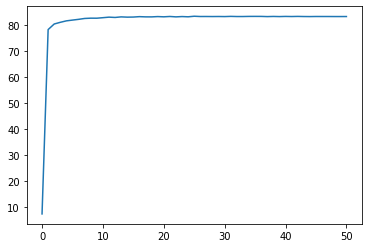

In [77]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

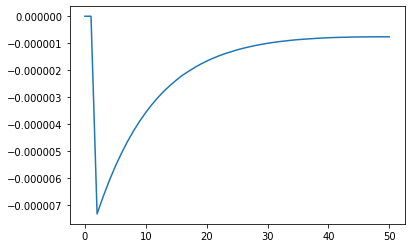

In [78]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [79]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
            print(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [80]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)


68.96239471435547
65.96459197998047
81.67076110839844
69.62139892578125
84.60395050048828
39.30740356445313
82.88538360595703
80.0684814453125
82.20054626464844
82.48481750488281
71.12030029296875
82.25222778320312
82.9112319946289
80.3333740234375
79.4547119140625
82.6980209350586
80.72748565673828
61.79092788696289
61.9136848449707
81.27018737792969
76.2049331665039
61.44204711914063
49.48313903808594
74.37007141113281
68.56182861328125
80.72102355957031
82.9112319946289
80.79855346679688
68.90425109863281
81.07637023925781
77.51001739501953
79.84235382080078
79.93927001953125
79.0282974243164
78.8538589477539
75.7332992553711
83.18904113769531
78.4662094116211
60.4858512878418
85.12081909179688
82.44605255126953
66.86264038085939
73.09083557128906
69.55033111572266
83.73821258544922
81.3218765258789
81.1474380493164
61.06085968017578
74.52513122558594
73.85321044921875
84.0224838256836
74.39591979980469
69.58909606933594
73.15544891357422
76.69595336914062
81.82582092285156
68.35508

In [81]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

79.76482391357422
79.31257629394531
76.7347183227539
80.63703155517578
82.7884750366211
79.26734924316406
83.26657104492188
78.07210540771484
82.43959045410156
65.10530853271484
40.786922454833984
61.09962463378906
79.77128601074219
75.18413543701172
79.30611419677734
80.52073669433594
80.22354125976562
58.49592971801758
77.30326843261719
82.74971008300781
82.3491439819336
76.48921203613281
61.04147720336914
64.16203308105469
58.27626419067383
65.16345977783203
76.72825622558594
79.92634582519531
78.75694274902344
81.87104034423828
76.34707641601562
81.17327880859375
80.47551727294922
83.6865234375
45.05750274658203
81.61260986328125
83.29241180419922
83.00167846679688
78.35637664794922
83.94495391845703
80.19123840332031
81.27664947509766
83.3311767578125
82.13593292236328
82.65925598144531
76.3858413696289
86.71662902832031
80.38506317138672
81.90980529785156
80.688720703125
87.69866943359375
77.78782653808594
60.89287948608398
75.84313201904297
72.41891479492188
80.01033782958984
72

## Select Data points

In [82]:
# only time series
def get_specific_inputs(input_data):
    N = len(input_data)
    config_features = np.zeros((N, 7))
    val_accuracy_till_ten_epoch = np.zeros((N, 10))

    for i in range(N):
        config_features[i][0] = input_data[i]["config"]["batch_size"]
        config_features[i][1] = input_data[i]["config"]["max_dropout"]
        config_features[i][2] = input_data[i]["config"]["max_units"]
        config_features[i][3] = input_data[i]["config"]["num_layers"]
        config_features[i][4] = input_data[i]["config"]["learning_rate"]
        config_features[i][5] = input_data[i]["config"]["momentum"]
        config_features[i][6] = input_data[i]["config"]["weight_decay"]
        val_accuracy_till_ten_epoch[i] = input_data[i]["Train/val_accuracy"][:10]

    return(np.concatenate((config_features, val_accuracy_till_ten_epoch), axis=1))

In [83]:
tr_data= get_specific_inputs(train_data)
tr_labels= np.c_[train_targets]


vl_data= get_specific_inputs(val_data)
vl_labels= np.c_[val_targets]

tst_data = get_specific_inputs(test_data)
tst_labels= np.c_[test_targets]

## Declare Networks

In [84]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# network hyperparameters
BATCH_SIZE = 10
EPOCHS = 50
SEQ_LEN = 1
INPUT_SIZE = tr_data.shape[1] 
kf = KFold(n_splits=4)

train_data = TensorDataset(torch.from_numpy(tr_data).float(), torch.from_numpy(tr_labels).float())
val_data = TensorDataset(torch.from_numpy(vl_data).float(), torch.from_numpy(vl_labels).float())
test_data = TensorDataset(torch.from_numpy(tst_data).float(), torch.from_numpy(tst_labels).float())

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [85]:
class standard_CNN(nn.Module):
    """
    A simple CNN that takes the single channel 17 valued vector of features.
    
    standard_CNN(
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
    (fc1): Linear(in_features=960, out_features=1, bias=True)
    )

    """
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE=1):
        super(standard_CNN, self).__init__()
        
        self.pool = nn.MaxPool1d(2, stride=1)
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.fc1 = nn.Linear(960, OUTPUT_SIZE)


    def forward(self, x):
        """
        Forward pass for the network.
        Args:
            input_lstm : the Train/val_accuracy time series Batch_Size*50.
            config_features : a vector of 7 variable features across run 
                              configurations as input to the CNN.
        """
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(BATCH_SIZE, -1)
        x = self.fc1(x)

        return x

In [97]:
class standard_LSTM(nn.Module):
    """
    standard_LSTM
    A simple one layer standard LSTM module followed by 2 fully connected layer.
    
    Net Architecture:
        standard_LSTM(
        (relu): ReLU()
        (lstm): LSTM(1, 100)
        (drop): Dropout(p=0.3, inplace=False)
        (fc1): Linear(in_features=5700, out_features=100, bias=True)
        (fc2): Linear(in_features=100, out_features=1, bias=True)
        )
    """
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE=1):
        super(standard_LSTM, self).__init__()
        self.input_dim=HIDDEN_SIZE
        self.n_layers=1
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=self.n_layers)
        self.hidden_state = torch.zeros(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.cell_state = torch.zeros(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.hidden = (self.hidden_state, self.cell_state)
        self.fc1 = nn.Linear(INPUT_SIZE*HIDDEN_SIZE, OUTPUT_SIZE)


    def forward(self, x):
        """
        Forward pass for the network.
        Args:
            x : a vector of 7 hyperparamter features prepended to 
            the 50 step Train/val_accuracy time series.
        """
        lstm_input = x.reshape(INPUT_SIZE,BATCH_SIZE, SEQ_LEN)
        out, (hn, cn) = self.lstm(lstm_input, self.hidden)
        out = out.view(BATCH_SIZE, -1)
        out = self.fc1(out)
        
        return out

In [87]:
class CNN_LSTM(nn.Module):
    """
    A two layer CNN used to extract configuration features which are further used 
    to initalize the initial hidden state of the 3 Layer LSTM network, followed
    by two fully connected layer to the output.
    
    Net Architecture:
        CNN_LSTM(
        (pool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
        (relu): ReLU()
        (drop): Dropout(p=0.4, inplace=False)
        (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv2): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (lstm): LSTM(1, 64, num_layers=3)
        (fc1): Linear(in_features=3200, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=1, bias=True)
    """
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE=1):
        super(CNN_LSTM, self).__init__()
        
        self.pool = nn.MaxPool1d(2, stride=1)
        self.relu = nn.ReLU()
        self.n_layers=1
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1, stride=1, padding=1)
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=self.n_layers)
        self.hidden_state = torch.randn(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.cell_state = torch.randn(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.hidden = (self.hidden_state, self.cell_state)
        self.fc1 = nn.Linear(INPUT_SIZE*HIDDEN_SIZE, OUTPUT_SIZE)


    def forward(self, input_lstm, config_features):
        """
        Forward pass for the network.
        Args:
            input_lstm : the Train/val_accuracy time series Batch_Size*50.
            config_features : a vector of 7 variable features across run 
                              configurations as input to the CNN.
        """
        config_features = self.pool(self.relu(self.conv1(config_features)))
        self.hidden_state = config_features.reshape(self.n_layers, BATCH_SIZE, 128)
        out, (hn, cn) = self.lstm(input_lstm.reshape(INPUT_SIZE ,BATCH_SIZE, SEQ_LEN), self.hidden)
        out = out.view(BATCH_SIZE, -1)
        out = self.fc1(out)

        return out

## Define train and test functions

In [90]:
def train_model(train_dataloader:DataLoader, validation_dataloader:DataLoader, 
                epochs, model:nn.Module, optimizer, scheduler, criterion):
    """
    train model and log train/validation losses.
    different train-validation input for CNN_LSTM 
    since we split the data to feed CNN and LSTM
    """
    
    global INPUT_SIZE
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        batch_losses = []
        training_loss = 0.0
        #training loop
        model = model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            if type(model) is CNN_LSTM:
                config_features, timestep_inputs = torch.split(inputs, [7,10], dim=1)   
                config_features = config_features.unsqueeze(1)
                INPUT_SIZE = timestep_inputs.shape[1]
                outputs = model(timestep_inputs, config_features)
            if type(model) is standard_LSTM:
                INPUT_SIZE = inputs.shape[1]
                outputs = model(inputs)
            if type(model) is standard_CNN:
                INPUT_SIZE = inputs.shape[1]
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
            loss = criterion(labels.float(), outputs)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
            #print("batch loss", loss)
            #print(f"[{epoch+1}] prediction while training: {outputs}\t ground truth: {labels}")
        training_loss = np.mean(batch_losses)
        train_losses.append(training_loss)
        scheduler.step()   
        #validation loop
        with torch.no_grad():
            val_losses = []
            validation_loss = 0.0
            model = model.eval()
            for val_inputs, val_labels in val_loader:
                if type(model) is CNN_LSTM:
                    val_config_features, val_inputs = torch.split(val_inputs, [7,10], dim=1)
                    val_config_features = val_config_features.unsqueeze(1)
                    INPUT_SIZE = val_inputs.shape[1]
                    outputs_vl= model(val_inputs, val_config_features)
                if type(model) is standard_LSTM:
                    INPUT_SIZE = val_inputs.shape[1]
                    outputs_vl= model(val_inputs)
                if type(model) is standard_CNN:
                    INPUT_SIZE = inputs.shape[1]
                    val_inputs = val_inputs.unsqueeze(1)
                    outputs_vl= model(val_inputs)
                loss = criterion(outputs_vl, val_labels)
                val_losses.append(loss.item())
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)
        print(f"[{epoch+1}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")
    #torch.save(model.state_dict(), "./cnn_lstm.pth")
    return train_losses, validation_losses
    #torch.save(model.state_dict(), MODEL_PATH)

In [91]:
def test_model(test_dataloader: DataLoader, model: nn.Module, criterion):
    test_losses = []
    with torch.no_grad():
        for _idx, data in enumerate(test_dataloader):
            inputs, labels = data
            model.eval()
            if type(model) is standard_CNN:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
            if type(model) is standard_LSTM:  
                outputs= model(inputs)
            if type(model) is CNN_LSTM:
                config_features, inputs = torch.split(inputs, [7,10], dim=1)
                config_features = config_features.unsqueeze(1)
                INPUT_SIZE = inputs.shape[1]
                outputs= model(inputs, config_features)
            #rescaled_outputs = inverse_scaler(outputs, method="minmax")
            #print("rescaled_outputs: ",rescaled_outputs.shape)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
        test_loss = np.mean(test_losses)
        print(f"Final test loss: {test_loss:.4f}")    
    return test_losses

## Train models

In [92]:
# toggle to debug
#torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### CNN

In [93]:
model = standard_CNN(INPUT_SIZE, HIDDEN_SIZE=64, OUTPUT_SIZE=1).to(device)
print(model)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam_optimizer, T_max=100)
mse_criterion = nn.MSELoss()

# train standard_CNN
training_losses, validation_losses = train_model(train_loader, val_loader, 50, model, adam_optimizer, cosine_scheduler, mse_criterion)

standard_CNN(
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=960, out_features=1, bias=True)
)
[1] Training loss: 512.6313	 Validation loss: 40.0749
[2] Training loss: 40.1577	 Validation loss: 31.8433
[3] Training loss: 32.9020	 Validation loss: 32.1997
[4] Training loss: 31.2382	 Validation loss: 29.8658
[5] Training loss: 21.5954	 Validation loss: 17.8438
[6] Training loss: 21.7899	 Validation loss: 20.2757
[7] Training loss: 20.7825	 Validation loss: 24.4094
[8] Training loss: 16.8962	 Validation loss: 14.8961
[9] Training loss: 16.5833	 Validation loss: 13.7842
[10] Training loss: 20.6292	 Validation loss: 13.1825
[11] Training loss: 14.1847	 Validation loss: 24.9323
[12] Training loss: 14.3529	 Validation loss: 12.5761
[13] Training loss: 12.8745	 Validation loss: 11.3625
[14] Training loss: 14.7826	 Validation loss: 15.6639
[15] Training loss

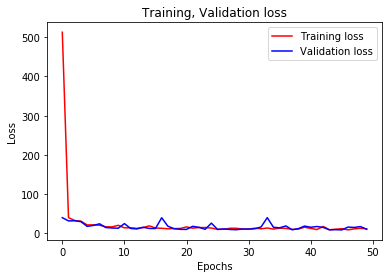

In [94]:
epochs = range(50)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training, Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig("standard_cnn_graph.pdf")

In [95]:
# test for standard_CNN
test_model(test_loader, model, nn.MSELoss())

Final test loss: 8.0261


[2.3871538639068604,
 4.193272113800049,
 15.417074203491211,
 4.815661430358887,
 2.631924629211426,
 2.4362099170684814,
 7.183906555175781,
 11.987704277038574,
 7.570713996887207,
 6.006966590881348,
 6.610826015472412,
 3.868687152862549,
 2.924220561981201,
 1.3990572690963745,
 35.30813980102539,
 3.738206148147583,
 7.28685998916626,
 5.005028247833252,
 2.4237046241760254,
 4.645281791687012,
 4.1721954345703125,
 6.904293060302734,
 2.2339580059051514,
 4.675358772277832,
 37.093528747558594,
 20.21306800842285,
 3.1794443130493164,
 22.923931121826172,
 7.799851894378662,
 6.677619934082031,
 3.497976779937744,
 8.057557106018066,
 4.715797424316406,
 2.9729342460632324,
 4.982100009918213,
 2.637732744216919,
 7.154458045959473,
 2.102966785430908,
 2.186558246612549,
 6.728592872619629,
 8.712992668151855,
 15.266166687011719,
 10.260396957397461,
 21.21295738220215,
 7.304348945617676,
 3.6037590503692627,
 4.727834224700928,
 3.283773899078369,
 13.61510181427002,
 14.56

### LSTM

In [99]:
model = standard_LSTM(INPUT_SIZE=17, HIDDEN_SIZE=100, OUTPUT_SIZE=1).to(device)
print(model)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam_optimizer, T_max=100)
mse_criterion = nn.MSELoss()

# train standard_LSTM
training_losses, validation_losses = train_model(train_loader, val_loader, 50, model, adam_optimizer, cosine_scheduler, mse_criterion)

standard_LSTM(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=1700, out_features=1, bias=True)
)
[1] Training loss: 1799.2772	 Validation loss: 179.2425
[2] Training loss: 120.7890	 Validation loss: 69.9435
[3] Training loss: 57.6208	 Validation loss: 35.4524
[4] Training loss: 33.6331	 Validation loss: 22.9670
[5] Training loss: 19.8369	 Validation loss: 15.4912
[6] Training loss: 15.5016	 Validation loss: 13.2288
[7] Training loss: 13.9458	 Validation loss: 13.1247
[8] Training loss: 12.9779	 Validation loss: 11.1923
[9] Training loss: 12.2592	 Validation loss: 12.3722
[10] Training loss: 11.9718	 Validation loss: 11.2257
[11] Training loss: 11.7849	 Validation loss: 9.8459
[12] Training loss: 11.2461	 Validation loss: 9.5927
[13] Training loss: 10.3543	 Validation loss: 10.0066
[14] Training loss: 11.1335	 Validation loss: 9.4361
[15] Training loss: 10.0538	 Validation loss: 9.9959
[16] Training loss: 10.4797	 Validation loss: 10.0997
[17] Training loss: 10.0736	 Validation loss

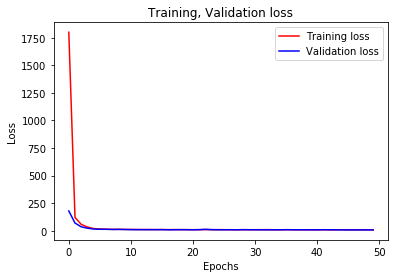

In [100]:
epochs = range(50)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training, Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig("standard_lstm_graph.pdf")

In [101]:
# test for standard_LSTM
test_model(test_loader, model, nn.MSELoss())

Final test loss: 6.1502


[3.1937568187713623,
 6.029017925262451,
 1.6541736125946045,
 3.1975109577178955,
 1.0496833324432373,
 1.5908687114715576,
 28.6745662689209,
 5.948151588439941,
 3.167576313018799,
 4.047338485717773,
 4.537236213684082,
 20.60457420349121,
 2.6917684078216553,
 6.506045341491699,
 3.5718040466308594,
 4.416800498962402,
 2.977417469024658,
 11.773897171020508,
 4.866450309753418,
 18.007678985595703,
 2.4243247509002686,
 4.993751049041748,
 26.94228744506836,
 1.7177846431732178,
 2.6248133182525635,
 1.677058458328247,
 15.950984001159668,
 11.752875328063965,
 5.887531280517578,
 2.1037371158599854,
 3.1592066287994385,
 14.550987243652344,
 4.244483947753906,
 13.289280891418457,
 6.085684776306152,
 0.4147115647792816,
 2.5180726051330566,
 5.951648712158203,
 8.946120262145996,
 4.450160026550293,
 2.5940184593200684,
 3.6524062156677246,
 4.1960248947143555,
 4.681188583374023,
 2.382190227508545,
 2.3018429279327393,
 3.6114609241485596,
 1.367842435836792,
 2.2509722709655

### CNN_LSTM

In [103]:
model = CNN_LSTM(INPUT_SIZE, HIDDEN_SIZE=128, OUTPUT_SIZE=1).to(device)
print(model)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam_optimizer, T_max=100)
mse_criterion = nn.MSELoss()

# train CNN_LSTM
training_losses, validation_losses = train_model(train_loader, val_loader, 50, model, adam_optimizer, cosine_scheduler, mse_criterion)

CNN_LSTM(
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv1d(1, 16, kernel_size=(1,), stride=(1,), padding=(1,))
  (lstm): LSTM(1, 128)
  (fc1): Linear(in_features=1280, out_features=1, bias=True)
)
[1] Training loss: 1950.0307	 Validation loss: 74.3187
[2] Training loss: 53.6196	 Validation loss: 28.6404
[3] Training loss: 22.4006	 Validation loss: 14.6053
[4] Training loss: 14.8685	 Validation loss: 11.3173
[5] Training loss: 12.0019	 Validation loss: 10.5539
[6] Training loss: 12.3112	 Validation loss: 11.4873
[7] Training loss: 11.1756	 Validation loss: 9.9623
[8] Training loss: 10.8211	 Validation loss: 9.1533
[9] Training loss: 10.7060	 Validation loss: 10.5451
[10] Training loss: 10.2997	 Validation loss: 10.7461
[11] Training loss: 10.7107	 Validation loss: 9.6561
[12] Training loss: 10.6654	 Validation loss: 9.4052
[13] Training loss: 10.2161	 Validation loss: 9.0347
[14] Training loss: 10.5017	 Validation lo

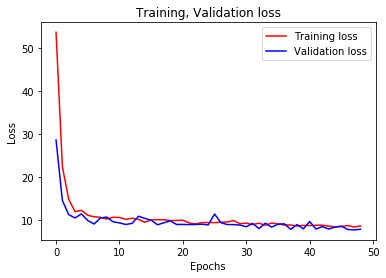

In [104]:
epochs = range(49)
plt.plot(epochs, training_losses[1:], 'r', label='Training loss')
plt.plot(epochs, validation_losses[1:], 'b', label='Validation loss')
plt.title('Training, Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig("cnn_lstm_graph.pdf")

In [105]:
# test for CNN_LSTM
test_model(test_loader, model, nn.MSELoss())

Final test loss: 5.8772


[1.070194959640503,
 6.274632930755615,
 2.9758193492889404,
 14.627772331237793,
 5.165252208709717,
 3.305554151535034,
 4.145155906677246,
 2.797847270965576,
 1.0707132816314697,
 15.290417671203613,
 5.980608940124512,
 1.0450865030288696,
 5.256745338439941,
 3.5281524658203125,
 1.193179726600647,
 2.7432150840759277,
 4.009439945220947,
 5.3090643882751465,
 7.74825382232666,
 1.008589267730713,
 7.789872646331787,
 3.865070343017578,
 22.832275390625,
 10.37870979309082,
 5.170827865600586,
 1.9067630767822266,
 1.0431430339813232,
 5.3266119956970215,
 7.59580135345459,
 1.5081722736358643,
 15.01435661315918,
 2.4928574562072754,
 3.5114223957061768,
 4.446469783782959,
 1.8097273111343384,
 1.4015992879867554,
 6.785832405090332,
 1.883545160293579,
 3.6074118614196777,
 8.782197952270508,
 1.585167646408081,
 6.573895454406738,
 3.088904619216919,
 7.634821891784668,
 29.70150375366211,
 10.588878631591797,
 2.391404151916504,
 2.7727575302124023,
 12.172006607055664,
 5.6